# Introduction to Modeling Flexibility

{cite}`farevuu2018` apply the simulated Real Estate Market to a basic Proforma
in two ways:
1. Using the `Market` pricing factors to adjust projected values for cash flows
   (by multiplying the factor against respective line items)
2. Programming 'decisions' into the Proforma that change how the Proforma
   operates, in response to conditions or characteristics of the `Market`
   dynamics

To begin with, let's see how *Rangekeeper* adjusts the projected Potential Gross
Income and Reversion cash flows, using a single scenario/trial of a `Market`.

Similar to the Deterministic Scenarios in
{doc}`/deterministic_scenarios.ipynb`, we import required libraries and set up
a base Model:


In [1]:
import locale
from typing import List
import pandas as pd

import rangekeeper as rk

In [2]:
locale.setlocale(locale.LC_ALL, 'en_au')
units = rk.measure.Index.registry
currency = rk.measure.register_currency(registry=units)
params = {
    'start_date': pd.Timestamp('2001-01-01'),
    'num_periods': 10,
    'period_type': rk.periodicity.Type.YEAR,
    'acquisition_cost': -1000 * currency.units,
    'initial_income': 100 * currency.units,
    'growth_rate': 0.02,
    'vacancy_rate': 0.05,
    'opex_pgi_ratio': 0.35,
    'capex_pgi_ratio': 0.1,
    'exit_caprate': 0.05,
    'discount_rate': 0.07
    }

## Base (Ex-Ante, Inflexible) Model
The Base (non-market-adjusted and inflexible) Model is the same as before:

In [3]:
class BaseModel:
    def __init__(self) -> None:
        pass
    
    def set_params(self, params: dict) -> None:
        self.params = params

Define Spans

In [4]:
@rk.update_class(BaseModel)
class BaseModel:
    def init_spans(self):
        self.calc_span = rk.span.Span.from_num_periods(
            name='Span to Calculate Reversion',
            date=self.params['start_date'],
            period_type=self.params['period_type'],
            num_periods=self.params['num_periods'] + 1)
        self.acq_span = rk.span.Span.from_num_periods(
            name='Acquisition Span',
            date=rk.periodicity.offset_date(
                self.params['start_date'],
                num_periods=-1,
                period_type=self.params['period_type']),
            period_type=self.params['period_type'],
            num_periods=1)
        self.span = self.calc_span.shift(
            name='Span',
            num_periods=-1,
            period_type=self.params['period_type'],
            bound='end')
        self.reversion_span = self.span.shift(
            name='Reversion Span',
            num_periods=self.params['num_periods'] - 1,
            period_type=self.params['period_type'],
            bound='start')

Define Calculations for Cash Flows

In [5]:
@rk.update_class(BaseModel)
class BaseModel:
    def calc_acquisition(self):
        self.acquisition = rk.flux.Flow.from_projection(
            name='Acquisition',
            value=self.params['acquisition_cost'],
            proj=rk.projection.Distribution(
                form=rk.distribution.Uniform(),
                sequence=self.acq_span.to_index(period_type=self.params['period_type'])),
            units=currency.units)

    def calc_egi(self):
        self.pgi = rk.flux.Flow.from_projection(
            name='Potential Gross Income',
            value=self.params['initial_income'],
            proj=rk.projection.Extrapolation(
                form=rk.extrapolation.Compounding(
                    rate=self.params['growth_rate']),
                sequence=self.calc_span.to_index(period_type=self.params['period_type'])),
            units=currency.units)
        self.vacancy = rk.flux.Flow(
            name='Vacancy Allowance',
            movements=self.pgi.movements * -self.params['vacancy_rate'],
            units=currency.units)
        self.egi = rk.flux.Stream(
            name='Effective Gross Income',
            flows=[self.pgi, self.vacancy],
            period_type=self.params['period_type']).sum()

    def calc_noi(self):
        self.opex = rk.flux.Flow(
            name='Operating Expenses',
            movements=self.pgi.movements * self.params['opex_pgi_ratio'],
            units=currency.units).invert()
        self.noi = rk.flux.Stream(
            name='Net Operating Income',
            flows=[self.egi, self.opex],
            period_type=self.params['period_type']).sum()

    def calc_ncf(self):
        self.capex = rk.flux.Flow(
            name='Capital Expenditures',
            movements=self.pgi.movements * self.params['capex_pgi_ratio'],
            units=currency.units).invert()
        self.net_cf = rk.flux.Stream(
            name='Net Annual Cashflow',
            flows=[self.noi, self.capex],
            period_type=self.params['period_type']).sum()

    def calc_reversion(self):
        self.reversions = rk.flux.Flow(
            name='Reversions',
            movements=self.net_cf.movements.shift(periods=-1).dropna() /
                      self.params['exit_caprate'],
            units=currency.units).trim_to_span(span=self.span)
        self.reversion = self.reversions.trim_to_span(
            span=self.reversion_span,
            name='Reversion')

        self.pbtcfs = rk.flux.Stream(
            name='PBTCFs',
            flows=[
                self.net_cf.trim_to_span(span=self.span),
                self.reversions.trim_to_span(span=self.reversion_span)
                ],
            period_type=self.params['period_type'])

Define Metrics

In [6]:
@rk.update_class(BaseModel)
class BaseModel:
    def calc_metrics(self):
        pvs = []
        irrs = []
        for period in self.net_cf.trim_to_span(span=self.span).movements.index:
            cumulative_net_cf = self.net_cf.trim_to_span(
                span=rk.span.Span(
                    name='Cumulative Net Cashflow Span',
                    start_date=self.params['start_date'],
                    end_date=period))
            reversion = rk.flux.Flow(
                movements=self.reversions.movements.loc[[period]],
                units=currency.units)
            cumulative_net_cf_with_rev = rk.flux.Stream(
                name='Net Cashflow with Reversion',
                flows=[
                    cumulative_net_cf,
                    reversion
                    ],
                period_type=self.params['period_type'])
            pv = cumulative_net_cf_with_rev.sum().pv(
                name='Present Value',
                period_type=self.params['period_type'],
                discount_rate=self.params['discount_rate'])
            pvs.append(pv.collapse().movements)

            incl_acq = rk.flux.Stream(
                name='Net Cashflow with Reversion and Acquisition',
                flows=[cumulative_net_cf_with_rev.sum(), self.acquisition],
                period_type=self.params['period_type'])

            irrs.append(round(incl_acq.sum().xirr(), 4))

        self.pvs = rk.flux.Flow(
            name='Present Values',
            movements=pd.concat(pvs),
            units=currency.units)
        self.irrs = rk.flux.Flow(
            name='Internal Rates of Return',
            movements=pd.Series(irrs, index=self.pvs.movements.index),
            units=None)

Wrap all definitions and calculations in a `execute()` method:

In [7]:
@rk.update_class(BaseModel)
class BaseModel:
    def generate(self):
        self.init_spans()
        self.calc_acquisition()
        self.calc_egi()
        self.calc_noi()
        self.calc_ncf()
        self.calc_reversion()
        self.calc_metrics()

This results in the 'Ex-Ante Realistic Traditional DCF Proforma':

In [8]:
ex_ante = BaseModel()
ex_ante.set_params(params)
ex_ante.generate()

In [9]:
ex_ante_table = rk.flux.Stream(
    name='Ex-Ante Pro-forma Cash Flow Projection',
    flows=[
        ex_ante.pgi,
        ex_ante.vacancy,
        ex_ante.egi,
        ex_ante.opex,
        ex_ante.noi,
        ex_ante.capex,
        ex_ante.net_cf,
        ex_ante.reversion,
        ],
    period_type=rk.periodicity.Type.YEAR
    )
ex_ante_table

date,Potential Gross Income,Vacancy Allowance,Effective Gross Income,Operating Expenses,Net Operating Income,Capital Expenditures,Net Annual Cashflow,Reversion
2001,$100.00,-$5.00,$95.00,-$35.00,$60.00,-$10.00,$50.00,0
2002,$102.00,-$5.10,$96.90,-$35.70,$61.20,-$10.20,$51.00,0
2003,$104.04,-$5.20,$98.84,-$36.41,$62.42,-$10.40,$52.02,0
2004,$106.12,-$5.31,$100.81,-$37.14,$63.67,-$10.61,$53.06,0
2005,$108.24,-$5.41,$102.83,-$37.89,$64.95,-$10.82,$54.12,0
2006,$110.41,-$5.52,$104.89,-$38.64,$66.24,-$11.04,$55.20,0
2007,$112.62,-$5.63,$106.99,-$39.42,$67.57,-$11.26,$56.31,0
2008,$114.87,-$5.74,$109.13,-$40.20,$68.92,-$11.49,$57.43,0
2009,$117.17,-$5.86,$111.31,-$41.01,$70.30,-$11.72,$58.58,0
2010,$119.51,-$5.98,$113.53,-$41.83,$71.71,-$11.95,$59.75,"$1,218.99"


The metrics for the Base Model are:

In [10]:
print('Projected IRR at Market Value Price: {:.2%}'.format(ex_ante.irrs.movements[-1]))
print('Time 0 Present Value at OCC: {0}'.format(locale.currency(ex_ante.pvs.movements[-1], grouping=True)))
print('Average Annual Cashflow: {0}'.format(locale.currency(ex_ante.net_cf.trim_to_span(ex_ante.span).movements.mean(), grouping=True)))

Projected IRR at Market Value Price: 7.00%
Time 0 Present Value at OCC: $1,000.00
Average Annual Cashflow: $54.75


```{warning}
Note that the holding period for the Base Model is fixed (inflexible) at 10
years.
```

```{note}
The Average Annual Cashflow is derived from the Operating cash flow only (not
counting reversion). This is to indicate the relative favorability of the
scenario outcomes in terms of the real estate space market, the fundamental
economic basis of the property value.

(From {cite}`farevuu2018`, accompanying Excel spreadsheets)
```

## Ex-Post Inflexible Model
The Ex-Post Model uses a simulated `Market` scenario to adjust the Base
Model's Potential Gross Income (PGI) and Reversion cash flows. In this case,
instead of using straight-line projected growth to calculate the PGI, we will
use the simulated `Market`'s Price Factors to adjust the Ex-Ante Model (and
emulate how an 'Ex-Post' Model would look)

### Market
First, we need to simulate a `Market` scenario:

In [11]:
period_type = rk.periodicity.Type.YEAR
num_periods = 25
span = rk.span.Span.from_num_periods(
    name="Span",
    date=pd.Timestamp(2000, 1, 1),
    period_type=period_type,
    num_periods=num_periods)
sequence = span.to_index(period_type=period_type)

Overall Trend:

In [12]:
trend = rk.dynamics.trend.Trend(
    sequence=sequence,
    cap_rate=.05,
    initial_value=0.050747414,
    growth_rate=-0.002537905)

Volatility:

In [13]:
volatility = rk.dynamics.volatility.Volatility(
    sequence=sequence,
    trend=trend,
    volatility_per_period=.1,
    autoregression_param=.2,
    mean_reversion_param=.3)

Cyclicality:

In [14]:
cyclicality = rk.dynamics.cyclicality.Cyclicality.from_estimates(
    space_cycle_phase_prop=0,
    space_cycle_period=13.8,
    space_cycle_height=1,
    space_cycle_asymmetric_parameter=.5,
    asset_cycle_period_diff=0.8,
    asset_cycle_phase_prop=-.05,
    asset_cycle_amplitude=.02,
    asset_cycle_asymmetric_parameter=.5,
    sequence=sequence)

Noise and Black Swan:

In [15]:
noise = rk.dynamics.noise.Noise(
    sequence=sequence,
    noise_dist=rk.distribution.Symmetric(
        type=rk.distribution.Type.TRIANGULAR,
        residual=.1))

black_swan = rk.dynamics.black_swan.BlackSwan(
    sequence=sequence,
    likelihood=.05,
    dissipation_rate=.3,
    probability=rk.distribution.Uniform(),
    impact=-.25)

Single Market Scenario:

In [16]:
market = rk.dynamics.market.Market(
    sequence=sequence,
    trend=trend,
    volatility=volatility,
    cyclicality=cyclicality,
    noise=noise,
    black_swan=black_swan)
table = rk.flux.Stream(
    name='Market Dynamics',
    flows=[
        market.trend,
        market.volatility.volatility,
        market.volatility.autoregressive_returns,
        market.volatility,
        market.cyclicality.space_waveform,
        market.space_market,
        market.cyclicality.asset_waveform,
        market.asset_market,
        market.asset_true_value,
        market.space_market_price_factors,
        market.noisy_value,
        market.historical_value,
        market.implied_rev_cap_rate,
        market.returns
        ],
    period_type=period_type)

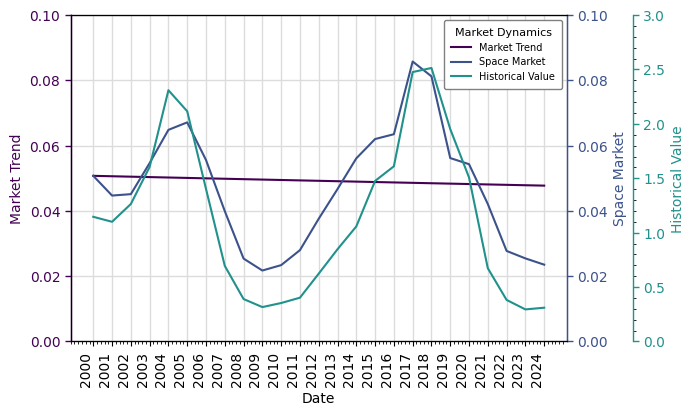

In [17]:
table.plot(
        flows={
            'Market Trend': (0, .1),
            'Space Market': (0, .1),
            'Historical Value': (0, 3)
            }
        )

```{warning}
Note where market peaks and troughs are!
```

### Model
Now we can duplicate and edit (subclass) the Base Model to create the Inflexible
Ex-Post Model.


In [18]:
class ExPostInflexModel(BaseModel):
    def set_market(self, market: rk.dynamics.market.Market) -> None:
        self.market = market

In order to use the simulated `Market`'s Space Market Price Factors to adjust
the Base Model's PGI, we need to override the `calc_egi()` method and instead
calculate the *product* of a `Stream` object whose two `Flow`s are the Base
Model's PGI and the simulated `Market`'s Space Market Price Factors:

In [19]:
@rk.update_class(ExPostInflexModel)
class ExPostInflexModel(BaseModel):
    def calc_egi(self):
        pgi = rk.flux.Flow.from_projection(
            name='Potential Gross Income',
            value=params['initial_income'],
            proj=rk.projection.Extrapolation(
                form=rk.extrapolation.Compounding(
                    rate=params['growth_rate']),
                sequence=self.calc_span.to_index(period_type=params['period_type'])),
            units=currency.units)

        # Construct a Stream that multiplies the Base Model's PGI by the
        # simulated Market's Space Market factors
        self.pgi = rk.flux.Stream(
            name='Potential Gross Income',
            flows=[
                pgi,
                market.space_market_price_factors.trim_to_span(self.calc_span)
                ],
            period_type=params['period_type']
            ).product(registry=rk.measure.Index.registry)
        
        self.vacancy = rk.flux.Flow(
            name='Vacancy Allowance',
            movements=self.pgi.movements * -params['vacancy_rate'],
            units=currency.units)
        self.egi = rk.flux.Stream(
            name='Effective Gross Income',
            flows=[self.pgi, self.vacancy],
            period_type=params['period_type']).sum()

Similarly, we override the `calc_reversion()` method to use the simulated
`Market`'s implied reversion cap rates to calculate the Reversions:

In [20]:
@rk.update_class(ExPostInflexModel)
class ExPostInflexModel(BaseModel):
    def calc_reversion(self):
        # Construct the Reversions using the simulated Market's Asset Market
        # factors (cap rates):
        self.reversions = rk.flux.Flow(
            name='Reversions',
            movements=self.net_cf.movements.shift(periods=-1).dropna() /
                      self.market.implied_rev_cap_rate.movements,
            units=currency.units).trim_to_span(span=self.span)
        
        self.reversion = self.reversions.trim_to_span(
            span=self.reversion_span,
            name='Reversion')
        self.pbtcfs = rk.flux.Stream(
            name='PBTCFs',
            flows=[
                self.net_cf.trim_to_span(span=self.span),
                self.reversions.trim_to_span(span=self.reversion_span)
                ],
            period_type=params['period_type'])

Copy the parameters and execute the model:

In [21]:
ex_post_params = params.copy()
ex_post_inflex = ExPostInflexModel()
ex_post_inflex.set_params(ex_post_params)
ex_post_inflex.set_market(market)
ex_post_inflex.generate()

In [22]:
ex_post_table = rk.flux.Stream(
    name='Ex-Ante Pro-forma Cash Flow Projection',
    flows=[
        ex_post_inflex.pgi,
        ex_post_inflex.vacancy,
        ex_post_inflex.egi,
        ex_post_inflex.opex,
        ex_post_inflex.noi,
        ex_post_inflex.capex,
        ex_post_inflex.net_cf,
        ex_post_inflex.reversion,
        ],
    period_type=rk.periodicity.Type.YEAR
    )
ex_post_table

date,Potential Gross Income,Vacancy Allowance,Effective Gross Income,Operating Expenses,Net Operating Income,Capital Expenditures,Net Annual Cashflow,Reversion
2001,$88.10,-$4.40,$83.69,-$30.83,$52.86,-$8.81,$44.05,0
2002,$90.71,-$4.54,$86.18,-$31.75,$54.43,-$9.07,$45.36,0
2003,$112.06,-$5.60,$106.46,-$39.22,$67.24,-$11.21,$56.03,0
2004,$135.57,-$6.78,$128.79,-$47.45,$81.34,-$13.56,$67.79,0
2005,$143.18,-$7.16,$136.02,-$50.11,$85.91,-$14.32,$71.59,0
2006,$120.96,-$6.05,$114.91,-$42.33,$72.57,-$12.10,$60.48,0
2007,$88.64,-$4.43,$84.21,-$31.02,$53.18,-$8.86,$44.32,0
2008,$57.48,-$2.87,$54.61,-$20.12,$34.49,-$5.75,$28.74,0
2009,$50.19,-$2.51,$47.68,-$17.57,$30.11,-$5.02,$25.09,0
2010,$55.08,-$2.75,$52.32,-$19.28,$33.05,-$5.51,$27.54,$424.38


We can compare models on the same metrics:

In [23]:
print('Projected IRR at Market Value Price: {:.2%}'.format(ex_post_inflex.irrs.movements[-1]))
print('Time 0 Present Value at OCC: {0}'.format(locale.currency(ex_post_inflex.pvs.movements[-1], grouping=True)))
print('Average Annual Cashflow: {0}'.format(locale.currency(ex_post_inflex.net_cf.trim_to_span(ex_post_inflex.span).movements.mean(), grouping=True)))

Projected IRR at Market Value Price: -1.48%
Time 0 Present Value at OCC: $557.29
Average Annual Cashflow: $47.10


In [24]:
pv_diff = (ex_post_inflex.pvs.movements[-1] - ex_ante.pvs.movements[-1]) / ex_ante.pvs.movements[-1]
print('Percentage Difference of Scenario PV Minus Pro-forma PV: {:.2%}'.format(pv_diff))

irr_diff = ex_post_inflex.irrs.movements[-1] - ex_ante.irrs.movements[-1]
print('Difference of Scenario IRR Minus Pro-forma IRR: {:.2%}'.format(irr_diff))

Percentage Difference of Scenario PV Minus Pro-forma PV: -44.27%
Difference of Scenario IRR Minus Pro-forma IRR: -8.48%


## Ex-Post Flexible Model
In attempting to capture the effects of *flexibility* in our Proforma, we must
introduce the ability to program optionality into our model; that is, the
creation of alternate options to a single course of action, that may be
exercised (but are not obliged to be)

In {cite}`farevuu2018`, Chapter 9 presents a simple case of flexibility; the
'Resale Timing Problem', which is described as the question of when and how to
decide to sell an investment property.

*Rangekeeper* formulates these types of decision problems as `Policy`s that
encapsulate the sequence of conditions required to trigger a decision, and the
option actions that are execised as a result.


### `Policy`s
`Policy`s adjust or edit a `Model` dynamically (e.g. by overwriting how it 
constructs its `Flow`s, `Stream`s, or metrics/outcomes), and thus enable the 
Proforma to be *flexible*.
They are structured as classes that require a 'state' (a specific `Flow`) to be 
checked for a certain 'condition', and if the condition is met, an 'action' on 
the `Model` is executed; producing a new `Model`.

```{figure} resources/FaREVuU-figure9.1.png
---
width: 75%
name: FaREVuU-figure9.1
---
Figure 9.1 From {cite}`farevuu2018`
```

{cite}`farevuu2018` diagram the logic of the "Stop-Gain Resale Rule" as a 
flowchart (influenced by Excel functions). In *Rangekeeper*, this would be 
programmed as simply adjusting the holding period of the asset (in effect 
bringing its reversion/sale to the specified period):

First we define our condition, taking a `Flow` as input and outputting a 
sequence of respective booleans that flag the state of the decision.

```{note}
Note an additional condition has been specified in the below code; that the
minimum hold period is 7 years. This is to prevent the model from triggering
consistently in the first few years as the `Market` phase has been fixed at '0'
(ie, the scenario always begins with a `Market` at mid-cycle going up)
```

In [25]:
def exceed_pricing_factor(state: rk.flux.Flow) -> List[bool]:
    threshold = 1.2
    result = []
    for i in range(state.movements.index.size):
        if any(result):
            result.append(False)
        else:
            if i < 7:
                result.append(False)
            else:
                if state.movements[i] > threshold:
                    result.append(True)
                else:
                    result.append(False)
    return result

Now we define our action; taking a `Model` object to manipulate, as well as the
resultant sequence of decisions from the previous condition check:

In [26]:
def adjust_hold_period(
        model: object,
        decisions: List[bool]) -> object:
    # Get the index of the decision flag:
    try:
        idx = decisions.index(True)
    except ValueError:
        idx = len(decisions)
        
    # Adjust the Model's holding period:
    policy_params = model.params.copy()
    policy_params['num_periods'] = idx

    # Re-run the Model with updated params:
    model.set_params(policy_params)
    model.generate()
    return model

Now that our functions have been defined, we wrap them in a `Policy` instance, 
that can be executed against the `Model` and its context (`Market`)

```{note}
The abstract nature of the `Policy` class implies the ability to chain multiple
`Policy`s together, thus building more complex graphs of actions that can better
mimic a manager or developer of a real estate asset. For more information, see
[Markov decision process](https://en.wikipedia.org/wiki/Markov_decision_process)

In [27]:
stop_gain_resale_policy = rk.policy.Policy(
    state=ex_post_inflex.market.space_market_price_factors,
    model=ex_post_inflex,
    condition=exceed_pricing_factor,
    action=adjust_hold_period)

In [28]:
ex_post_flex = stop_gain_resale_policy.execute()

print('Flexible Model Hold Period: {0}'.format(ex_post_flex.params['num_periods']))
print('Projected IRR at Market Value Price: {:.2%}'.format(ex_post_flex.irrs.movements[-1]))
print('Time 0 Present Value at OCC: {0}'.format(locale.currency(ex_post_flex.pvs.movements[-1], grouping=True)))
print('Average Annual Cashflow: {0}'.format(locale.currency(ex_post_flex.net_cf.trim_to_span(ex_post_inflex.span).movements.mean(), grouping=True)))

Flexible Model Hold Period: 15
Projected IRR at Market Value Price: 8.44%
Time 0 Present Value at OCC: $1,168.25
Average Annual Cashflow: $50.74


In this situation, flexibility is a benefit to the investor, as Stop-Gain Resale
Policy encourages holding the asset until the market peaks, and avoids market
downturns.